# Cook's membrane - data driven

In [1]:
import numpy as np
import pandas as pd
import altair as alt
import pyvista as pv
import deepxde as dde

from pinnDSE.geom import *
from pinnDSE.viz import *
from pinnDSE.elasticity import *
from pinnDSE.bc import *

# --UNITS--
# displacement: mm
# stress: MPa
# force: N
# E = 2e5 MPa (AISI Carbon Steel)
# nu = 0.27
# rho = 7.85e-3 
# yield = 490 MPa

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


2 read mesh: 0.005983829498291016


3 coordinate transform: 2.51723051071167
2 read results: 3.4228248596191406
1 total mesh and result loading: 3.5564663410186768
1 total edge processing: 0.14960122108459473


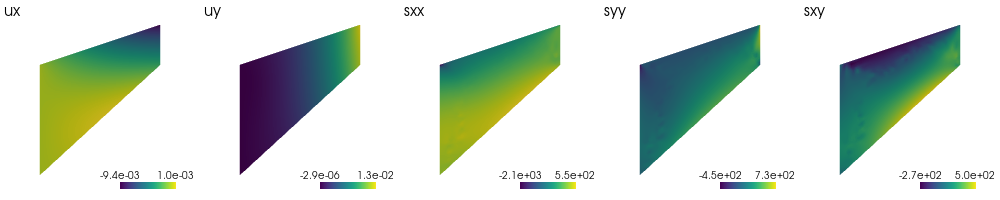

In [2]:
op2File = 'data/cooksMembrane/v1.0/cooksMembrane02.op2'
geom = MeshGeom(op2File, thickness=1.0)
plotScalarFields(geom.mesh, geom.resDf)

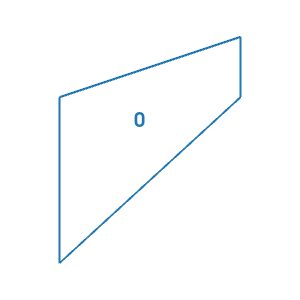

In [3]:
drawBoundaries(geom.bndDict)

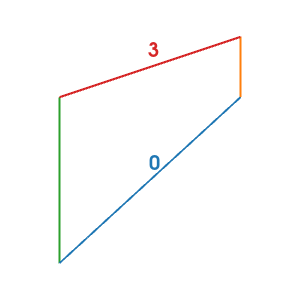

In [4]:
# by default every continuous edge forms a single boundary. We can further split the boundary like this
mask = getCellMask(geom.bndDict[0], component=0, func=lambda x: (x[:,0]>0.68).all())
newBndDict, newBndNormsDict = splitBoundary(geom.bndDict, geom.bndNormsDict, 0, mask)

mask = getCellMask(newBndDict[0], component=0, func=lambda x: (x[:,0]<-0.5).all())
newBndDict, newBndNormsDict = splitBoundary(newBndDict, newBndNormsDict, 0, mask)

mask = getCellMask(newBndDict[0], component=0, func=lambda x: (x[:,1]>0.24).all())
newBndDict, newBndNormsDict = splitBoundary(newBndDict, newBndNormsDict, 0, mask)

drawBoundaries(newBndDict)

In [5]:
# now update the boundary metadata
geom.bndDict, geom.bndNormsDict = newBndDict, newBndNormsDict
geom.updateBndLengthAndArea()

### Data-driven: Dense PC with DataSet class

Compiling model...
Building feed-forward neural network...
'build' took 0.048903 s

'compile' took 0.340117 s

Initializing variables...
Training model...

Step      Train loss    Test loss     Test metric
0         [4.25e+04]    [4.44e+04]    []  
10        [3.12e+04]    [3.27e+04]    []  
20        [1.56e+04]    [1.66e+04]    []  
30        [5.69e+03]    [6.77e+03]    []  
40        [6.31e+03]    [7.42e+03]    []  
50        [5.12e+03]    [6.17e+03]    []  
60        [4.88e+03]    [5.87e+03]    []  
70        [4.47e+03]    [5.45e+03]    []  
80        [4.07e+03]    [4.98e+03]    []  
90        [3.63e+03]    [4.49e+03]    []  
100       [3.20e+03]    [4.02e+03]    []  
110       [2.85e+03]    [3.63e+03]    []  
120       [2.59e+03]    [3.35e+03]    []  
130       [2.41e+03]    [3.15e+03]    []  
140       [2.27e+03]    [3.00e+03]    []  
150       [2.14e+03]    [2.86e+03]    []  
160       [2.01e+03]    [2.73e+03]    []  
170       [1.90e+03]    [2.61e+03]    []  
180       [1.79e+03]

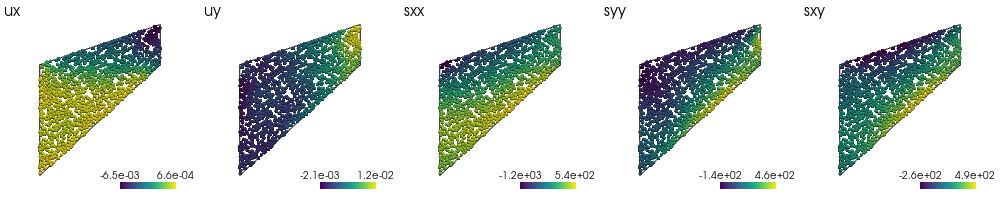

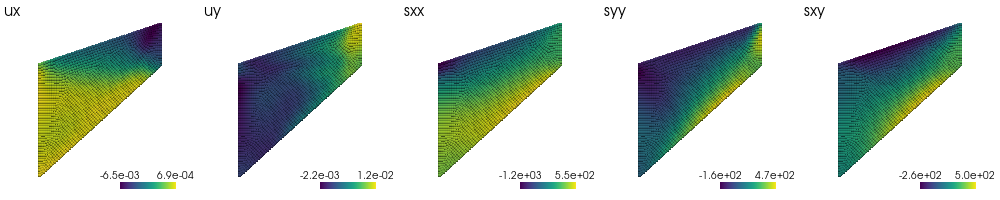

In [56]:
# train on dense point cloud
X_train = sampleDomain(geom.mesh, 1000, seed=1234)[:,:2]
y_train = geom.sampleRes(X_train).drop(columns='vonMises').values

# test on FEA nodes
X_test = np.array(geom.mesh.points[:,:2])
y_test = geom.resDf.drop(columns='vonMises').values

data = dde.data.DataSet(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

# build model
net = dde.maps.FNN([2] + [64]*4  + [5], "tanh", "Glorot uniform")
outScales = np.array([1e-3, 1e-2, 1e2, 1e2, 1e2]) # [ux,uy,sxx,syy,sxy]
net.apply_output_transform(lambda x,y : y*outScales) 
model = dde.Model(data, net)

# train
model.compile("adam", lr=0.001)
losshistory1, train_state = model.train(epochs=1000, display_every=10)

# test
pred = model.predict(X_train)
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(addZ(X_train))
plotScalarFields(pc, predDf, bndDict=geom.bndDict)

pred = model.predict(X_test)
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(addZ(X_test))
plotScalarFields(pc, predDf)

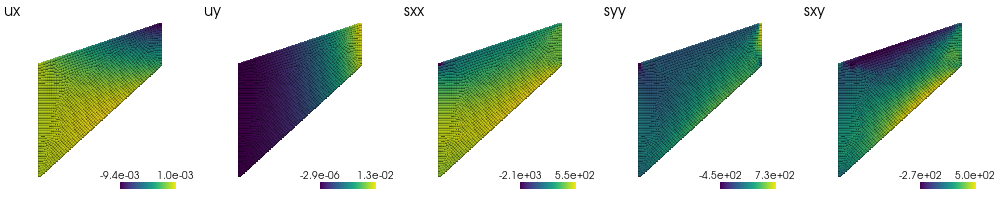

In [57]:
# ground trush
plotScalarFields(pc, geom.resDf)

# errors = predDf-geom.resDf
# maxes = pd.concat([intResDf, predDf]).abs().max()
# MAE = errors.abs().mean()
# RMAE = MAE/maxes
# RMAE

In [59]:
def trainTestLossPlot(losshistory):
    lossTrain = np.vstack(losshistory.loss_train)
    lossTest = np.vstack(losshistory.loss_test)
    steps = losshistory.steps
    lossDf = pd.DataFrame(np.hstack([lossTrain,lossTest]), columns=['train', 'test'])
    lossDf['step'] = np.array(losshistory.steps)
    return alt.Chart(lossDf).transform_fold(
        ['train', 'test'],
        as_=['loss term', 'value']
    ).mark_line().encode(
        x='step:Q',
        y=alt.Y('value:Q', scale=alt.Scale(type='linear')),
        color=alt.Color('loss term:N', title='', sort=['train', 'test']),
        tooltip=['loss term:N', 'value:Q', 'step:Q']
    )

print(losshistory1.loss_test[-1])
trainTestLossPlot(losshistory1)

[467.13727]


alt.Chart(...)

### Data-driven: Sparse PC with DataSet class

Compiling model...
Building feed-forward neural network...
'build' took 0.050896 s

'compile' took 0.355067 s

Initializing variables...
Training model...

Step      Train loss    Test loss     Test metric
0         [2.92e+04]    [4.32e+04]    []  
10        [1.85e+04]    [3.32e+04]    []  
20        [1.23e+04]    [2.21e+04]    []  
30        [5.68e+03]    [1.03e+04]    []  
40        [1.30e+03]    [8.55e+03]    []  
50        [1.75e+03]    [1.11e+04]    []  
60        [1.29e+03]    [7.86e+03]    []  
70        [1.29e+03]    [7.84e+03]    []  
80        [1.23e+03]    [8.38e+03]    []  
90        [1.21e+03]    [8.41e+03]    []  
100       [1.19e+03]    [8.06e+03]    []  
110       [1.17e+03]    [8.11e+03]    []  
120       [1.16e+03]    [8.05e+03]    []  
130       [1.14e+03]    [7.95e+03]    []  
140       [1.12e+03]    [7.86e+03]    []  
150       [1.09e+03]    [7.75e+03]    []  
160       [1.06e+03]    [7.60e+03]    []  
170       [1.02e+03]    [7.41e+03]    []  
180       [9.54e+02]

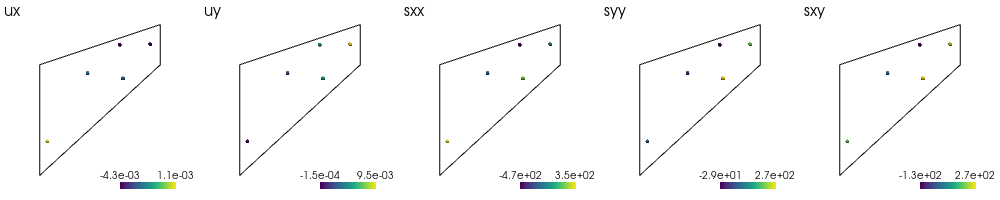

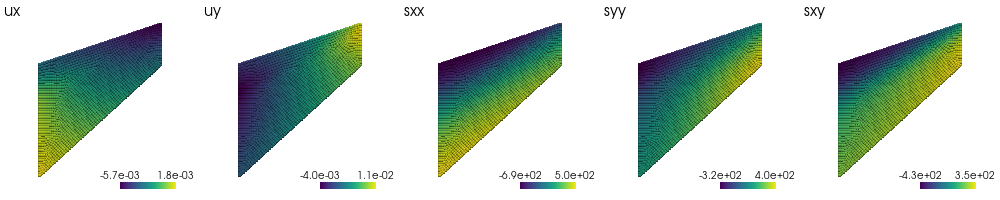

In [60]:
# train on dense point cloud
X_train = sampleDomain(geom.mesh, 5, seed=1234)[:,:2]
y_train = geom.sampleRes(X_train).drop(columns='vonMises').values

# test on FEA nodes
X_test = np.array(geom.mesh.points[:,:2])
y_test = geom.resDf.drop(columns='vonMises').values

data = dde.data.DataSet(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

# build model
net = dde.maps.FNN([2] + [64]*4  + [5], "tanh", "Glorot uniform")
outScales = np.array([1e-3, 1e-2, 1e2, 1e2, 1e2]) # [ux,uy,sxx,syy,sxy]
net.apply_output_transform(lambda x,y : y*outScales) 
model = dde.Model(data, net)

# train
model.compile("adam", lr=0.001)
losshistory2, train_state = model.train(epochs=1000, display_every=10)

# test
pred = model.predict(X_train)
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(addZ(X_train))
plotScalarFields(pc, predDf, bndDict=geom.bndDict)

pred = model.predict(X_test)
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(addZ(X_test))
plotScalarFields(pc, predDf)

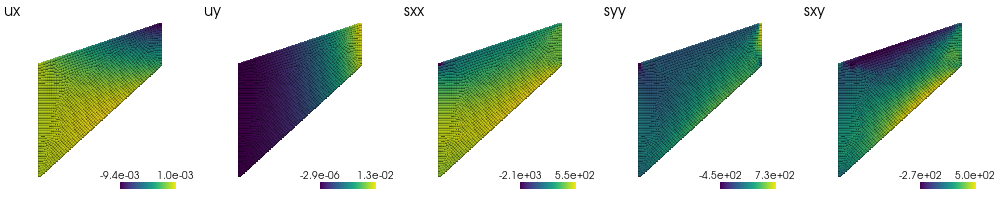

In [61]:
# ground trush
plotScalarFields(pc, geom.resDf)

In [62]:
print(losshistory2.loss_test[-1])
trainTestLossPlot(losshistory2)

[5804.368]


alt.Chart(...)

### Data-driven: Dense PC with PDE class (dummy pde)

Compiling model...
Building feed-forward neural network...
'build' took 0.052892 s

'compile' took 0.810843 s

Initializing variables...
Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [5.44e-06, 2.16e-05, 1.30e+05, 3.54e+04, 4.52e+04]    [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  

Best model at step 0:
  train loss: 2.10e+05
  test loss: 0.00e+00
  test metric: []

'train' took 2.023697 s

Compiling model...
'compile' took 0.267312 s

Initializing variables...
Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [1.11e+00, 1.05e+00, 1.11e+00, 9.05e-01, 1.09e+00]    [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
20        [4.64e-01, 7.82e-02, 8.94e-01, 5.03e-01, 6.56e-01]    [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
40        [2

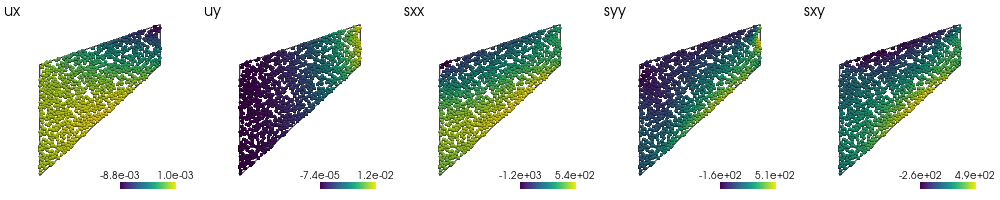

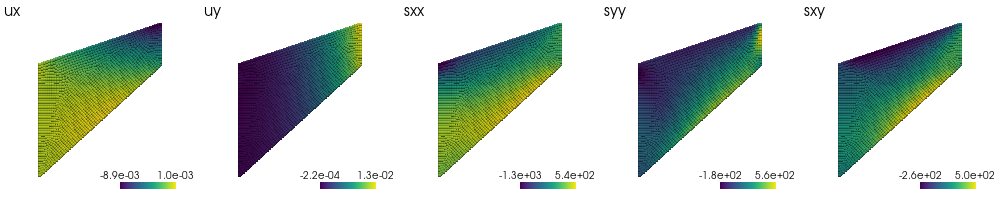

In [96]:
# train on dense point cloud
X_train = sampleDomain(geom.mesh, 1000, seed=1234)[:,:2]
y_train = geom.sampleRes(X_train).drop(columns='vonMises').values

# test on FEA nodes
X_test = np.array(geom.mesh.points[:,:2])
y_test = geom.resDf.drop(columns='vonMises').values

# PointSetBC class implements data-driven terms as a BC object
ux = dde.boundary_conditions.PointSetBC(X_train, y_train[:,0].reshape(-1,1), component=0)
uy = dde.boundary_conditions.PointSetBC(X_train, y_train[:,1].reshape(-1,1), component=1)
sxx = dde.boundary_conditions.PointSetBC(X_train, y_train[:,2].reshape(-1,1), component=2)
syy = dde.boundary_conditions.PointSetBC(X_train, y_train[:,3].reshape(-1,1), component=3)
sxy = dde.boundary_conditions.PointSetBC(X_train, y_train[:,4].reshape(-1,1), component=4)

# problem setup
# bndNumSamplesDir = {0: 800, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200}
bndNumSamplesDir = {bndId:0 for bndId,l in geom.bndLensDict.items()}
paramDict = {'E':2e5, 'nu':0.3}
bcList = [ux,uy,sxx,syy,sxy]
data = StrctPDE(geom, 
            lambda x: 0, 
            bcList, 
            num_domain=1, 
            num_boundary_dir=bndNumSamplesDir, 
            num_test=0,
            paramDict=paramDict)

data.test_x = X_test
data.test_y = y_test

for bc in bcList:
    if isinstance(bc, TractionBC): 
        bc.train_n = data.train_n

# build model
net = dde.maps.FNN([2] + [64]*4  + [5], "tanh", "Glorot uniform")
outScales = np.array([1e-3, 1e-2, 1e2, 1e2, 1e2]) # [ux,uy,sxx,syy,sxy]
net.apply_output_transform(lambda x,y : y*outScales) 
model = dde.Model(data, net)

# get the unweighted loss values
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=0)
lw = losshistory.loss_train[0]**(-1) 

# train
model.compile("adam", lr=0.001, loss_weights=lw)
losshistory3, train_state = model.train(epochs=2000, display_every=20)

# test
pred = model.predict(X_train)
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(addZ(X_train))
plotScalarFields(pc, predDf, bndDict=geom.bndDict)

pred = model.predict(X_test)
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(addZ(X_test))
plotScalarFields(pc, predDf)

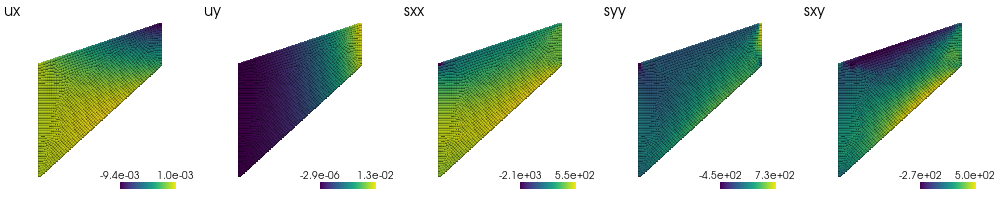

In [68]:
# ground trush
plotScalarFields(pc, geom.resDf)

In [97]:
bcNames = ['ux', 'uy', 'sxx', 'syy', 'sxy']
lossPlot(losshistory3, bcNames, pdeTermNames=[], scaleType='log', )

alt.Chart(...)

### Data-driven: Sparse PC with PDE class (dummy pde)

Compiling model...
Building feed-forward neural network...
'build' took 0.049866 s

'compile' took 1.308643 s

Initializing variables...
Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [6.83e-06, 1.92e-05, 9.42e+04, 2.87e+04, 4.07e+04]    [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  

Best model at step 0:
  train loss: 1.64e+05
  test loss: 0.00e+00
  test metric: []

'train' took 1.964757 s

Compiling model...
'compile' took 0.255273 s

Initializing variables...
Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [1.04e+00, 7.62e-01, 1.08e+00, 9.41e-01, 1.02e+00]    [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
20        [4.03e-01, 6.46e-02, 7.71e-01, 2.68e-01, 6.16e-01]    [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
40        [2

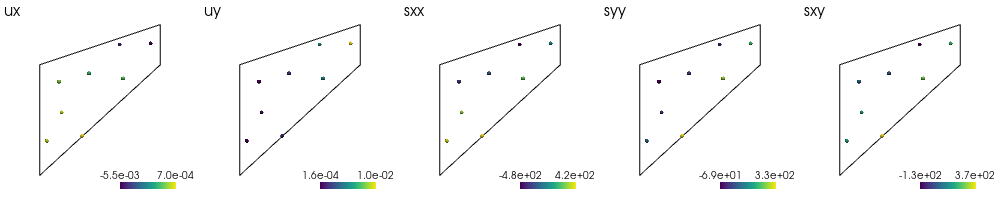

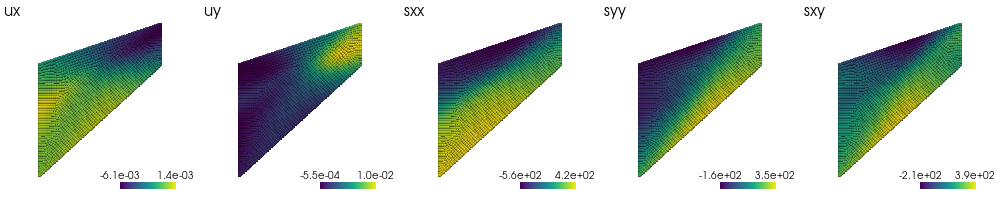

In [98]:
# train on dense point cloud
X_train = sampleDomain(geom.mesh, 8, seed=1234)[:,:2]
y_train = geom.sampleRes(X_train).drop(columns='vonMises').values

# test on FEA nodes
X_test = np.array(geom.mesh.points[:,:2])
y_test = geom.resDf.drop(columns='vonMises').values

# PointSetBC class implements data-driven terms as a BC object
ux = dde.boundary_conditions.PointSetBC(X_train, y_train[:,0].reshape(-1,1), component=0)
uy = dde.boundary_conditions.PointSetBC(X_train, y_train[:,1].reshape(-1,1), component=1)
sxx = dde.boundary_conditions.PointSetBC(X_train, y_train[:,2].reshape(-1,1), component=2)
syy = dde.boundary_conditions.PointSetBC(X_train, y_train[:,3].reshape(-1,1), component=3)
sxy = dde.boundary_conditions.PointSetBC(X_train, y_train[:,4].reshape(-1,1), component=4)

# problem setup
# bndNumSamplesDir = {0: 800, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200}
bndNumSamplesDir = {bndId:0 for bndId,l in geom.bndLensDict.items()}
paramDict = {'E':2e5, 'nu':0.3}
bcList = [ux,uy,sxx,syy,sxy]
data = StrctPDE(geom, 
            lambda x: 0, 
            bcList, 
            num_domain=1, 
            num_boundary_dir=bndNumSamplesDir, 
            num_test=0,
            paramDict=paramDict)

data.test_x = X_test
data.test_y = y_test

for bc in bcList:
    if isinstance(bc, TractionBC): 
        bc.train_n = data.train_n

# build model
net = dde.maps.FNN([2] + [64]*4  + [5], "tanh", "Glorot uniform")
outScales = np.array([1e-3, 1e-2, 1e2, 1e2, 1e2]) # [ux,uy,sxx,syy,sxy]
net.apply_output_transform(lambda x,y : y*outScales) 
model = dde.Model(data, net)

# get the unweighted loss values
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=0)
lw = losshistory.loss_train[0]**(-1) 

# train
model.compile("adam", lr=0.001, loss_weights=lw)
losshistory3, train_state = model.train(epochs=2000, display_every=20)

# test
pred = model.predict(X_train)
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(addZ(X_train))
plotScalarFields(pc, predDf, bndDict=geom.bndDict)

pred = model.predict(X_test)
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(addZ(X_test))
plotScalarFields(pc, predDf)

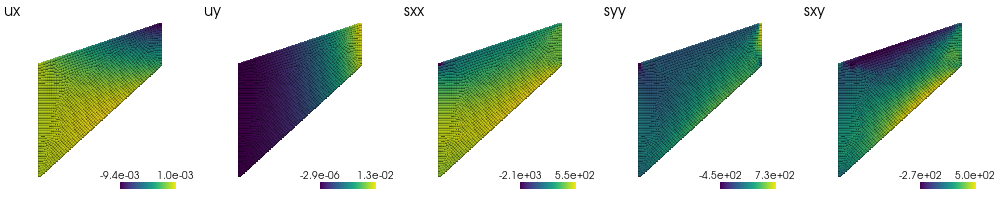

In [99]:
# ground trush
plotScalarFields(pc, geom.resDf)

In [100]:
bcNames = ['ux', 'uy', 'sxx', 'syy', 'sxy']
lossPlot(losshistory3, bcNames, pdeTermNames=[], scaleType='log', )

alt.Chart(...)

### hybrid

Compiling model...
Building feed-forward neural network...
'build' took 0.047871 s

'compile' took 1.951569 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                                                                              Test loss                                                                                                                                                                               Test metric
0         [1.22e+03, 1.20e+03, 9.16e+04, 1.31e+06, 1.88e+04, 2.48e-08, 3.16e-06, 2.38e+02, 2.45e+01, 1.86e+01, 6.04e+06, 2.43e+02, 3.52e+00, 6.58e-06, 1.64e-05, 9.66e+04, 2.94e+04, 4.18e+04]    [1.28e+03, 1.24e+03, 9.42e+04, 1.35e+06, 1.92e+04, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  

Best model at step 0:
  train loss: 7.63e+06
  test loss: 1.47e+06
  t

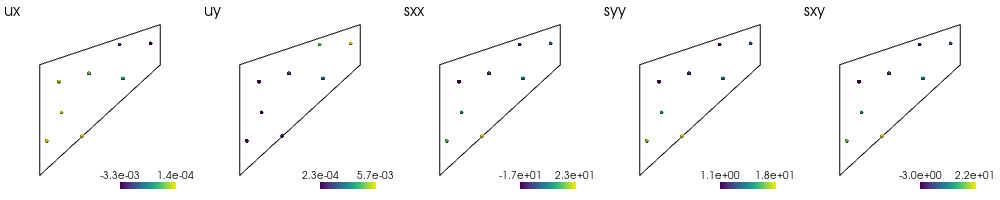

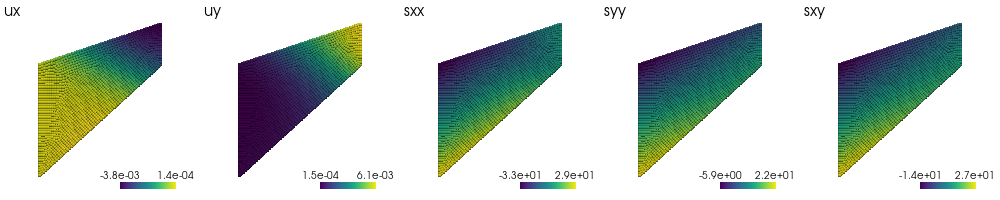

In [110]:
# train on dense point cloud
X_train = sampleDomain(geom.mesh, 8, seed=1234)[:,:2]
y_train = geom.sampleRes(X_train).drop(columns='vonMises').values

# test on FEA nodes
X_test = np.array(geom.mesh.points[:,:2])
y_test = geom.resDf.drop(columns='vonMises').values

# supports
xSup = SupportBC(geom, bndId=2, U=0, component=0)
ySup = SupportBC(geom, bndId=2, U=0, component=1)

# free edges
xTr0 = TractionBC(geom, bndId=0, T=0, component=0)
yTr0 = TractionBC(geom, bndId=0, T=0, component=1)

xTr3 = TractionBC(geom, bndId=3, T=0, component=0)
yTr3 = TractionBC(geom, bndId=3, T=0, component=1)

# loaded edges
xTr1 = TractionBC(geom, bndId=1, T=0, component=0)
yTr1 = TractionBC(geom, bndId=1, T=1000/geom.bndAreaDict[1], component=1)

# PointSetBC class implements data-driven terms as a BC object
ux = dde.boundary_conditions.PointSetBC(X_train, y_train[:,0].reshape(-1,1), component=0)
uy = dde.boundary_conditions.PointSetBC(X_train, y_train[:,1].reshape(-1,1), component=1)
sxx = dde.boundary_conditions.PointSetBC(X_train, y_train[:,2].reshape(-1,1), component=2)
syy = dde.boundary_conditions.PointSetBC(X_train, y_train[:,3].reshape(-1,1), component=3)
sxy = dde.boundary_conditions.PointSetBC(X_train, y_train[:,4].reshape(-1,1), component=4)

# problem setup
# bndNumSamplesDir = {0: 800, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200}
bndNumSamplesDir = {bndId:int(l*200) for bndId,l in geom.bndLensDict.items()}
paramDict = {'E':2e5, 'nu':0.3}
bcList = [xSup,ySup,xTr0,yTr0,xTr1,yTr1,xTr3,yTr3,ux,uy,sxx,syy,sxy]
data = StrctPDE(geom, 
            elasticityEqs, 
            bcList, 
            num_domain=1000, 
            num_boundary_dir=bndNumSamplesDir, 
            num_test=500,
            paramDict=paramDict)

data.test_x = X_test
data.test_y = y_test

for bc in bcList:
    if isinstance(bc, TractionBC): 
        bc.train_n = data.train_n

# build model
net = dde.maps.FNN([2] + [64]*4  + [5], "tanh", "Glorot uniform")
outScales = np.array([1e-3, 1e-2, 1e2, 1e2, 1e2]) # [ux,uy,sxx,syy,sxy]
net.apply_output_transform(lambda x,y : y*outScales) 
model = dde.Model(data, net)

# get the unweighted loss values
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=0)
lw = losshistory.loss_train[0]**(-1) 

# train
model.compile("adam", lr=0.001, loss_weights=lw)
losshistory4, train_state = model.train(epochs=2000, display_every=20)

# test
pred = model.predict(X_train)
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(addZ(X_train))
plotScalarFields(pc, predDf, bndDict=geom.bndDict)

pred = model.predict(X_test)
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(addZ(X_test))
plotScalarFields(pc, predDf)

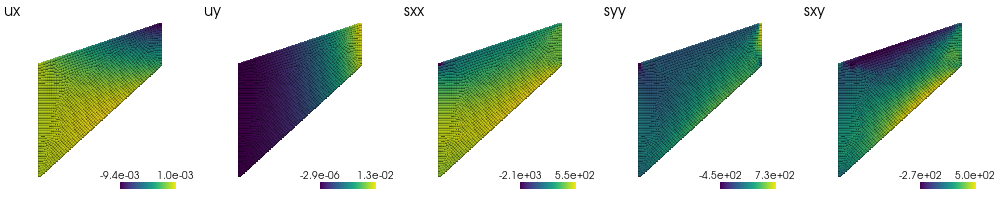

In [107]:
# ground trush
plotScalarFields(pc, geom.resDf)

In [111]:
bcNames = ['xSup','ySup','xTr0','yTr0','xTr1','yTr1','xTr3','yTr3','ux', 'uy', 'sxx', 'syy', 'sxy']
lossPlot(losshistory4, bcNames, scaleType='log')

alt.Chart(...)